In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt

In [2]:
env = gym.make('MountainCar-v0')

In [3]:
number_of_state_parameters = env.observation_space.shape[0]
number_of_possible_actions = env.action_space.n

custom_parameter_bins = 20

q_table_parameter_bins = [custom_parameter_bins] * number_of_state_parameters 
q_table_size = q_table_parameter_bins + [number_of_possible_actions,]

state_parameter_sample = env.observation_space.sample()
state_parameters_range = env.observation_space.high - env.observation_space.low
state_parameters_dividor = (state_parameters_range) / q_table_parameter_bins


print(f'number_of_state_parameters : {number_of_state_parameters}')
print(f'number_of_possible_actions : {number_of_possible_actions}')

print('-----------------------------')

print(f'custom_parameter_bins      : {custom_parameter_bins}')
print(f'q_table_parameter_bins     : {q_table_parameter_bins}')      
print(f'q_table_size               : {q_table_size}')      

print('-----------------------------')
print(f'state_parameter_sample     : {state_parameter_sample}')
print(f'state_parameters_range     : {state_parameters_range}')
print(f'state_parameters_dividor   : {state_parameters_dividor}')      

number_of_state_parameters : 2
number_of_possible_actions : 3
-----------------------------
custom_parameter_bins      : 20
q_table_parameter_bins     : [20, 20]
q_table_size               : [20, 20, 3]
-----------------------------
state_parameter_sample     : [ 0.1785793  -0.04055936]
state_parameters_range     : [1.8000001 0.14     ]
state_parameters_dividor   : [0.09  0.007]


In [4]:
def make_discrete(state1):
    discrete_state1 = (state1 - env.observation_space.low)/state_parameters_dividor
    discrete_state1 = tuple(discrete_state1.astype(np.int)) 
    return(discrete_state1)

In [5]:
def get_q_array(state2):
    discrete_state2 = make_discrete(state2)
    q_array = q_table[discrete_state2]
    return(q_array)

In [22]:
def get_action_epsilon(epsilon,current_state):
    if np.random.random() > epsilon:
        current_q_array = get_q_array(current_state)
        current_q_action = np.argmax(current_q_array)
    else:
        current_q_action = np.random.randint(low = 0, high = number_of_possible_actions)
        
    return(current_q_action)

In [7]:
def get_new_q(reward, new_state, current_state, current_q_action):
    max_future_q_array = get_q_array(new_state)            
    max_future_q_value = np.max(max_future_q_array)
    current_q_value = q_table[make_discrete(current_state) + (current_q_action,)]

    #Calculate actual new Q Value and it on Q_Table
    new_q = (1 - learning_rate) * current_q_value + learning_rate * (reward + max_future_q_value * discount)
    return(new_q)

In [10]:
epsilon = 1
start_decay_episode = 1
stop_decay_divider = 1.4

stop_decay_episode = episodes // stop_decay_divider
epsilon_decay_value = epsilon/(stop_decay_episode - start_decay_episode)

In [20]:
learning_rate = 0.1
discount = 0.95
episodes = 10000
show_every = episodes//5

In [8]:
q_table = np.random.uniform(low = -2, high = 1, size = q_table_size)

In [23]:
%%time

all_episode_total_reward = []
stats = {'ep':[],'avg':[],'min':[],'max':[]}

for episode in range(episodes):
    done = False
    current_state = env.reset()
    episode_total_reward = 0
    
    while not done:            
 
        #Move Agent by Q value
        current_q_action = get_action_epsilon(epsilon,current_state)      
        new_state, reward, done, info = env.step(current_q_action)

        episode_total_reward += reward        

        if episode % show_every == 0:
            env.render()        
        
    
        #Update Q Value
        if not done:
            new_q = get_new_q(reward, new_state, current_state, current_q_action)
            q_table[make_discrete(current_state) + (current_q_action,)] =  new_q
                    
        elif new_state[0] >= env.goal_position:
            q_table[make_discrete(current_state) + (current_q_action,)] = 0            
            if episode % show_every == 0:
                print(f'Reached flag in episode : {episode}')
        
        current_state = new_state 
        
    #Update Epsilon
    if stop_decay_episode >= episode >= start_decay_episode:
        epsilon -= epsilon_decay_value
                     
    #Update Stats
    all_episode_total_reward.append(episode_total_reward)    
    if episode % show_every == 0:
        stats['ep'].append(episode)
        stats['avg'].append(sum(all_episode_total_reward[-show_every:])/show_every)
        stats['min'].append(min(all_episode_total_reward[-show_every:]))    
        stats['max'].append(max(all_episode_total_reward[-show_every:]))
        
env.close()        

Reached flag in episode : 0
Reached flag in episode : 20
Reached flag in episode : 40
Reached flag in episode : 60
Reached flag in episode : 80
Wall time: 6.1 s


# Epsilon Analyser

In [12]:
def analyze_epsilon(epsilon = 1, episodes = 100, start_decay_episode = 1, stop_decay_divider = 1.4):
    
    stop_decay_episode = episodes // stop_decay_divider
    epsilon_decay_value = epsilon/(stop_decay_episode - start_decay_episode)
    
    print('epsilon_decay_value',epsilon_decay_value)

    calculated_ep = 0
    random_ep = 0
    episode_val = []
    epsilon_val = []

    for episode in range(episodes):
        if np.random.random() > epsilon:
            calculated_ep += 1
            val = 2
        else:
            random_ep += 1
            val = 1

        episode_val.append(val)
        if stop_decay_episode >= episode >= start_decay_episode:
            epsilon -= epsilon_decay_value

        epsilon_val.append(epsilon)

    print('calculated_ep : ',calculated_ep)
    print('random_ep : ',random_ep)

    plt.plot(range(episodes), episode_val, epsilon_val)

epsilon_decay_value 0.0001400364094664613
calculated_ep :  6416
random_ep :  3584


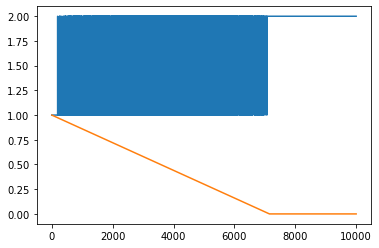

In [19]:
analyze_epsilon(epsilon = 1, 
                episodes = episodes, 
                start_decay_episode = start_decay_episode, 
                stop_decay_divider = stop_decay_divider)